## **Credit Card Default Detection**

### **A. Introduction**

- **Name**  : Livia Amanda Annafiah
- **Dataset** : [Credit Card Default](https://console.cloud.google.com/bigquery?p=bigquery-public-data&d=ml_datasets&t=credit_card_default&page=table&project=hacktiv8-sql-417802&ws=!1m9!1m3!3m2!1sbigquery-public-data!2sml_datasets!1m4!4m3!1sbigquery-public-data!2sml_datasets!3scredit_card_default)

---------------------

**Problem Statement**

The company struggles to assess credit risks accurately, requiring an advanced model to **predict default probabilities** in upcoming periods. Default occurs when borrowers fail to meet credit card payments, leading to financial losses, increased costs for recovery efforts, and can hurt company's reputation.

To address these challenges, the company needs an advanced predictive model that can forecast default probabilities for borrowers in the upcoming periods. By accurately predicting default risks, the company can take proactive measures to minimize losses, manage risks effectively, and improve overall financial stability and performance.

**Objective**

This project aims to to develop a classification model using `K-Nearest Neighbors (KNN)`, `Support Vector Machine (SVM)`, and `Logistic Regression` algorithms to forecast credit card defaults for the next month. The evaluation metric employed for model performance assessment is the `Recall` to calculate each model's performance.

### **B. Query SQL**

These are the query used to load the dataset from Big Query and is converted to .csv to create the model in Visual Studio Code.

```sql
from google.colab import auth
from google.cloud import bigquery
import pandas as pd

auth.authenticate_user()
print('Authenticated')

project_id = "hacktiv8-sql-417802"
client = bigquery.Client(project=project_id)

df = client.query('''
SELECT limit_balance, 
    CAST(sex AS INT64) AS sex,
    CAST(education_level AS INT64) AS education_level,
    CAST(marital_status AS INT64) AS marital_status,
    age,
    pay_0,
    pay_2,
    pay_3,
    pay_4,
    CAST(pay_5 AS FLOAT64) AS pay_5,
    CAST(pay_6 AS FLOAT64) AS pay_6,
    bill_amt_1,
    bill_amt_2,
    bill_amt_3,
    bill_amt_4,
    bill_amt_5,
    bill_amt_6,
    pay_amt_1,
    pay_amt_2,
    pay_amt_3,
    pay_amt_4,
    pay_amt_5,
    pay_amt_6,
    CAST(default_payment_next_month AS INT64) AS default_payment_next_month
FROM `bigquery-public-data.ml_datasets.credit_card_default`
LIMIT 10010
''').to_dataframe()

df.to_csv('P1G5_Set_1_livia_amanda.csv')
```

### **C. Libraries**

The libraries used to develop the model are as follows:

In [1]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik
import pickle

# Import libraries for data preprocessing
from sklearn.model_selection import train_test_split
from feature_engine.outliers import Winsorizer

# Import libraries for model creation and evaluation
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import recall_score, confusion_matrix, ConfusionMatrixDisplay

**Libraries Function**
- pandas: data manipulation and analysis
- matplotlib : data visualization and statistical plotting
- seaborn: data visualization and statistical plotting
- phik: feature selection
- pickle: saving model
- sklearn: machine learning algorithms, model creation, feature engineering, and evaluation
- feature engine: handling outliers

### **D. Data Loading & Cleaning**

In this section, the data is loaded and cleaned to make sure the analysis is based on accurate and reliable information.

#### **i. Data Loading**

This part will concentrate on loading and exploring the data. Initially, the process starts with loading the data and taking a brief glance at its contents.

In [2]:
# Load dataset
df_ori = pd.read_csv('P1G5_Set_1_livia_amanda.csv')

# Duplicate dataset
df = df_ori.copy()

# Show the first 10 data
df.head(10)

,Unnamed: 0,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
0,0,80000.0,1,6,1,54.0,0.0,0.0,0.0,0.0,...,29296.0,26210.0,17643.0,2545.0,2208.0,1336.0,2232.0,542.0,348.0,1
1,1,200000.0,1,4,1,49.0,0.0,0.0,0.0,0.0,...,50146.0,50235.0,48984.0,1689.0,2164.0,2500.0,3480.0,2500.0,3000.0,0
2,2,20000.0,2,6,2,22.0,0.0,0.0,0.0,0.0,...,1434.0,500.0,0.0,4641.0,1019.0,900.0,0.0,1500.0,0.0,1
3,3,260000.0,2,4,2,33.0,0.0,0.0,0.0,0.0,...,27821.0,30767.0,29890.0,5000.0,5000.0,1137.0,5000.0,1085.0,5000.0,0
4,4,150000.0,1,4,2,32.0,0.0,0.0,0.0,-1.0,...,150464.0,143375.0,146411.0,4019.0,146896.0,157436.0,4600.0,4709.0,5600.0,0
5,5,300000.0,2,4,2,32.0,0.0,0.0,0.0,0.0,...,65150.0,-450.0,700.0,15235.0,1491.0,1303.0,0.0,2000.0,1400.0,0
6,6,130000.0,1,1,1,45.0,0.0,0.0,0.0,0.0,...,62377.0,63832.0,65099.0,2886.0,2908.0,2129.0,2354.0,2366.0,2291.0,0
7,7,200000.0,1,1,1,58.0,0.0,0.0,0.0,0.0,...,124647.0,126921.0,129167.0,7822.0,4417.0,4446.0,4597.0,4677.0,4698.0,0
8,8,500000.0,1,1,1,39.0,0.0,0.0,0.0,0.0,...,174500.0,137406.0,204975.0,54209.0,4607.0,4603.0,5224.0,207440.0,7509.0,0
9,9,230000.0,1,1,1,48.0,0.0,0.0,0.0,0.0,...,105508.0,108101.0,110094.0,7000.0,6607.0,3773.0,4290.0,4164.0,2000.0,0


The result displays the initial 10 entries from the dataset, which includes details about each client such as age, gender, education level, as well as information regarding their payments, bills, and whether they defaulted on their payment the following month. The next step is to display the last 10 entries from the dataset.

In [3]:
# Show the last 10 data
df.tail(10)

,Unnamed: 0,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
2955,2955,360000.0,2,2,2,26.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,463.0,2500.0,0.0,0.0,0.0,0.0,0
2956,2956,100000.0,1,3,1,40.0,0.0,0.0,-1.0,-1.0,...,0.0,0.0,0.0,2000.0,2377.0,40000.0,0.0,0.0,0.0,0
2957,2957,30000.0,2,3,1,48.0,1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,200.0,0.0,0.0,0.0,0.0,0.0,0
2958,2958,80000.0,2,3,1,39.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,5000.0,5000.0,5000.0,0.0,5000.0,5000.0,470.0,0
2959,2959,20000.0,1,3,2,26.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,1560.0,0.0,0.0,0.0,0.0,0.0,0
2960,2960,80000.0,2,3,2,28.0,-1.0,-1.0,-1.0,-2.0,...,0.0,0.0,0.0,2800.0,0.0,0.0,0.0,0.0,0.0,0
2961,2961,50000.0,2,3,1,51.0,-1.0,-1.0,-1.0,-1.0,...,0.0,0.0,0.0,300.0,5880.0,0.0,0.0,0.0,0.0,1
2962,2962,450000.0,2,2,1,38.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,390.0,390.0,780.0,390.0,390.0,390.0,390.0,1
2963,2963,50000.0,2,2,1,44.0,-2.0,-2.0,-2.0,-2.0,...,390.0,390.0,0.0,390.0,390.0,390.0,390.0,0.0,780.0,0
2964,2964,290000.0,2,2,1,39.0,1.0,-2.0,-2.0,-2.0,...,3184.0,390.0,390.0,10000.0,800.0,3184.0,390.0,390.0,6617.0,0


The output reveals the dataset's last 10 entries. Observing both the beginning and end of the dataset suggests that certain categorical columns are already numerically encoded. To gain a deeper understanding of each column's unique values, here's a table presenting the information for each column.

<center>

| Column Name                     | Brief Description                                  | Encoded Categorical Meanings                                                            |
|---------------------------------|-----------------------------------------------------|-----------------------------------------------------------------------------------------|
| Unnamed:0                            | Client identifier                                   |                                                                                      |
| limit_balance                   | Credit limit amount in New Taiwan dollars (NTD)     |                                                                                     |
| sex                             | Gender of the client                                | 1=male, 2=female                                                                        |
| education_level                 | Level of education attained by the client            | 0=unknown, 1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown           |
| marital_status                  | Marital status of the client                         | 0=unknown, 1=married, 2=single, 3=others                                                           |
| age                             | Age of the client                                   |                                                                                     |
| pay_0                           | Repayment status in September 2005                  | -1=pay duly, 1=delayed payment (1 month), 2=delayed payment (2 months), ... 8=delayed payment (8 months), 9=delayed payment (>= 9 months)|
| pay_2                           | Repayment status in August 2005                     | Same encoding as pay_0                                                                   |
| pay_3                           | Repayment status in July 2005                       | Same encoding as pay_0                                                                   |
| pay_4                           | Repayment status in June 2005                       | Same encoding as pay_0                                                                   |
| pay_5                           | Repayment status in May 2005                        | Same encoding as pay_0                                                                   |
| pay_6                           | Repayment status in April 2005                      | Same encoding as pay_0                                                                   |
| bill_amt_1                      | Bill statement amount in September 2005             |                                                                                      |
| bill_amt_2                      | Bill statement amount in August 2005                |                                                                                      |
| bill_amt_3                      | Bill statement amount in July 2005                  |                                                                                      |
| bill_amt_4                      | Bill statement amount in June 2005                  |                                                                                      |
| bill_amt_5                      | Bill statement amount in May 2005                   |                                                                                      |
| bill_amt_6                      | Bill statement amount in April 2005                 |                                                                                      |
| pay_amt_1                       | Previous payment amount in September 2005           |                                                                                      |
| pay_amt_2                       | Previous payment amount in August 2005              |                                                                                      |
| pay_amt_3                       | Previous payment amount in July 2005                |                                                                                      |
| pay_amt_4                       | Previous payment amount in June 2005                |                                                                                      |
| pay_amt_5                       | Previous payment amount in May 2005                 |                                                                                      |
| pay_amt_6                       | Previous payment amount in April 2005               |                                                                                      |
| default_payment_next_month      | Indicates if the client defaulted the next month     | 1=yes, 0=no                                                                             |

For deeper insights into the data, the `info` method is used to check the summary information of the dataset.

In [4]:
# Check data summary
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  2965 non-null   int64  
 1   limit_balance               2965 non-null   float64
 2   sex                         2965 non-null   int64  
 3   education_level             2965 non-null   int64  
 4   marital_status              2965 non-null   int64  
 5   age                         2965 non-null   float64
 6   pay_0                       2965 non-null   float64
 7   pay_2                       2965 non-null   float64
 8   pay_3                       2965 non-null   float64
 9   pay_4                       2965 non-null   float64
 10  pay_5                       2965 non-null   float64
 11  pay_6                       2965 non-null   float64
 12  bill_amt_1                  2965 non-null   float64
 13  bill_amt_2                  2965 

The dataset contains **2965 entries** and **25 columns**. The results indicate that there are no missing values in any column, and the data types have been converted to numerical format in Google Colab previously. As a result, there is no need to address missing values or modify any data types.

These columns will be categorized based on their types for easier handling in future processes.

<center>

| **Category**  | **Type**     | **Column Names**                                           |
|---------------|--------------|------------------------------------------------------------|
| **Categorical** | **Ordinal Encoded**   | `educational_level`, `age`, `pay_0`, `pay_2`, `pay_3`,|               
|                 |                        | `pay_4`, `pay_5`, `pay_6`                                         |
|               | **Nominal Encoded**  | `sex`, `marital_status`         |
| **Numerical**   | **Discrete**  | `Unnamed: 0`, `limit_balance`, `age`            |
|               | **Continuous**| `bill_amt_1`, `bill_amt_2`, `bill_amt_3`, `bill_amt_4`,       |
|               |              | `bill_amt_5`, `bill_amt_6`, `pay_amt_1`, `pay_amt_2`,        |
|               |              | `pay_amt_3`, `pay_amt_4`, `pay_amt_5`, `pay_amt_6`  |

Next, the statistical summary of the data can be obtained using the `describe` method.

In [5]:
# Check descriptive statistictis
df.describe()

,Unnamed: 0,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
count,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000,...,2965.000000,2965.000000,2965.000000,2965.000000,2.965000e+03,2965.000000,2965.000000,2965.000000,2965.000000,2965.000000
mean,1482.000000,163369.308600,1.607757,1.849578,1.559865,35.193255,0.005059,-0.122428,-0.141653,-0.185160,...,44089.683305,40956.080607,39773.072513,6348.902867,6.272494e+03,5150.497133,4561.376054,4913.286678,5382.701518,0.214165
std,856.066099,125030.415472,0.488333,0.778184,0.522317,9.109439,1.114395,1.180784,1.183630,1.178322,...,61907.454056,58271.904751,57303.488981,20885.735336,2.887967e+04,14287.079982,13281.499599,16734.340778,17275.953029,0.410311
min,0.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-46627.000000,-46627.000000,-73895.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,741.000000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2582.000000,1958.000000,1430.000000,1013.000000,9.900000e+02,477.000000,313.000000,323.000000,173.000000,0.000000
50%,1482.000000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,...,19894.000000,18814.000000,18508.000000,2234.000000,2.175000e+03,1994.000000,1600.000000,1646.000000,1615.000000,0.000000
75%,2223.000000,230000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,...,58622.000000,53373.000000,52287.000000,5087.000000,5.000000e+03,4500.000000,4000.000000,4021.000000,4081.000000,0.000000
max,2964.000000,800000.000000,2.000000,6.000000,3.000000,69.000000,8.000000,7.000000,7.000000,8.000000,...,488808.000000,441981.000000,436172.000000,493358.000000,1.227082e+06,199209.000000,202076.000000,388071.000000,403500.000000,1.000000


The  result shows a statistical summary of the dataset. Across several columns, such as `age`, the mean values are relatively close to the median values. This suggests a symmetric distribution for these variables. However, there are differences in certain columns like `limit_balance`, where the mean is higher than the median, indicating a right-skewed distribution with some higher-value outliers. It indicates that some columns have **outliers** that needs handling.

The `nunique` method is used to check the total of unique values in each column to determine the handling process.

In [6]:
# Check total unique values
df.nunique()

Unnamed: 0                    2965
limit_balance                   59
sex                              2
education_level                  7
marital_status                   4
age                             49
pay_0                           11
pay_2                           10
pay_3                            9
pay_4                           10
pay_5                            9
pay_6                            8
bill_amt_1                    2643
bill_amt_2                    2592
bill_amt_3                    2549
bill_amt_4                    2504
bill_amt_5                    2482
bill_amt_6                    2461
pay_amt_1                     1415
pay_amt_2                     1372
pay_amt_3                     1302
pay_amt_4                     1214
pay_amt_5                     1194
pay_amt_6                     1189
default_payment_next_month       2
dtype: int64

There are some columns, such as `sex`, `educational_level`, `marital_status`, etc. that only have limited unique values.

The next exploration is to check whether the dataset have any duplicated rows using a method called `duplicated()`.

In [7]:
# Check total of duplicated rows
df.duplicated().sum()

0

The `sum()` method shows the total number of the duplicated rows. In this case, there are no duplicated rows which means each rows are unique and there is no need to drop any row.

Lastly, the missing values from each columns are checked using method `isnull()`.

In [8]:
# Check missing values
df.isnull().sum()

Unnamed: 0                    0
limit_balance                 0
sex                           0
education_level               0
marital_status                0
age                           0
pay_0                         0
pay_2                         0
pay_3                         0
pay_4                         0
pay_5                         0
pay_6                         0
bill_amt_1                    0
bill_amt_2                    0
bill_amt_3                    0
bill_amt_4                    0
bill_amt_5                    0
bill_amt_6                    0
pay_amt_1                     0
pay_amt_2                     0
pay_amt_3                     0
pay_amt_4                     0
pay_amt_5                     0
pay_amt_6                     0
default_payment_next_month    0
dtype: int64

Fortunately, there are no missing values in the dataset, eliminating the need to handle missing values.

#### **ii. Data Cleaning**

After exploring the dataset, it's clear that most data is already cleaned and requires no further handling. However, the column `Unnamed: 0` will be dropped as it serves as a unique identifier and does not correlate with the `default_payment_next_month` variable.

In [9]:
# Drop column
df = df.drop(columns=['Unnamed: 0'])

#### **iii. Data Checking**

To verify that the cleaning processes are complete, the `info` method is used again to check the summary data after cleaning.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2965 entries, 0 to 2964
Data columns (total 24 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   limit_balance               2965 non-null   float64
 1   sex                         2965 non-null   int64  
 2   education_level             2965 non-null   int64  
 3   marital_status              2965 non-null   int64  
 4   age                         2965 non-null   float64
 5   pay_0                       2965 non-null   float64
 6   pay_2                       2965 non-null   float64
 7   pay_3                       2965 non-null   float64
 8   pay_4                       2965 non-null   float64
 9   pay_5                       2965 non-null   float64
 10  pay_6                       2965 non-null   float64
 11  bill_amt_1                  2965 non-null   float64
 12  bill_amt_2                  2965 non-null   float64
 13  bill_amt_3                  2965 

The dataset now contains 24 columns and the `Unnamed: 0` column has been successfully removed, indicating that the cleaning process has been completed correctly.

### **E. Exploratory Data Analysis (EDA)**

After completing the data cleaning process, the next step is to explore the data distribution using visualization tools like bar charts, pie charts, and so forth.

##### **i. Gender Percentages**

The initial step is to assess the composition of clients based on their gender (male or female).

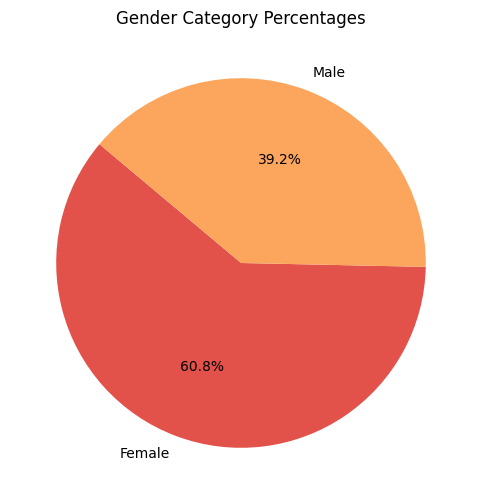

In [11]:
# Replace numerical labels with its name
sex_category = df['sex'].replace({1: 'Male',
                                  2: 'Female'})

# Count the occurrences of sex categories
sex_counts = sex_category.value_counts()

# Calculate the percentage for each sex category
sex_percentages = (sex_counts / sex_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(sex_percentages, labels=sex_percentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Spectral'))
plt.title('Gender Category Percentages')
plt.show()


The dataset indicates a dominance of females, accounting for 60.8% of the clients, while males make up 39.2%. This suggests a higher representation of females in this company's client base.

##### **ii. Educational Level**

The next step involves exploring the educational levels of all clients.

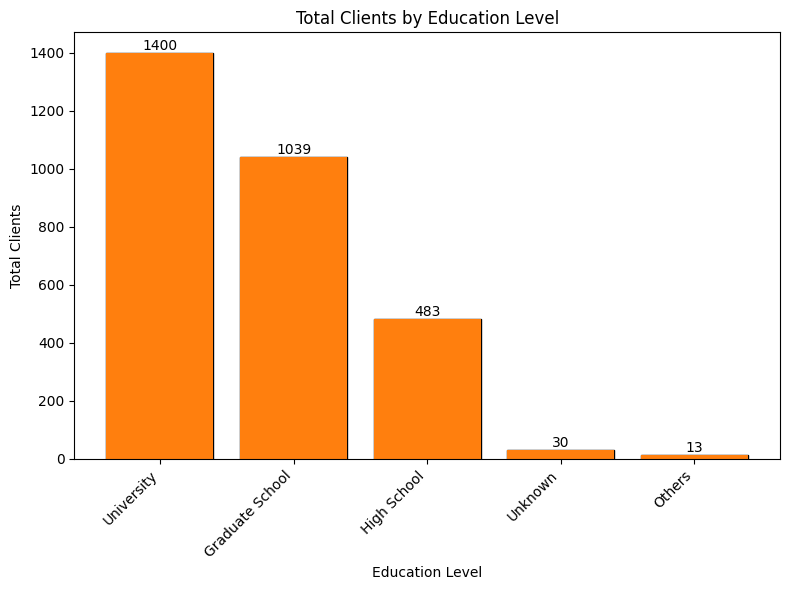

In [12]:
# Replace numerical labels with its name
edu_category = df['education_level'].replace({0: 'Unknown',
                                              1: 'Graduate School',
                                              2: 'University',
                                              3: 'High School',
                                              4: 'Others',
                                              5: 'Unknown',
                                              6: 'Unknown'})

# Count the occurrences of each education category
edu_level_counts = edu_category.value_counts().sort_values(ascending=False)

# Convert index labels to strings for plotting
x_labels = edu_level_counts.index.astype(str)
y_values = edu_level_counts.values

# Plotting the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, edgecolor='black')
plt.bar(x_labels, y_values)
plt.xlabel('Education Level')
plt.ylabel('Total Clients')
plt.title('Total Clients by Education Level')
plt.xticks(rotation=45, ha='right')

# Adding the text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show()


The bar chart shows the total number of clients categorized by their educational levels, with X representing the education level and Y representing the total number of clients. The highest number of clients are from the university level (1400 people), followed by graduate school (1039) and high school (483). However, there are also 30 clients with an unknown education level, along with 13 others whose education level is not specified.

Based on the data presented in the bar chart, it can be concluded that the majority of clients fall into higher education categories, specifically university and graduate school levels. This indicates that a significant portion of clients seeking services or products likely have advanced educational backgrounds.

#### **iii. Marital Status**

The next step is to explore the marital status of clients.

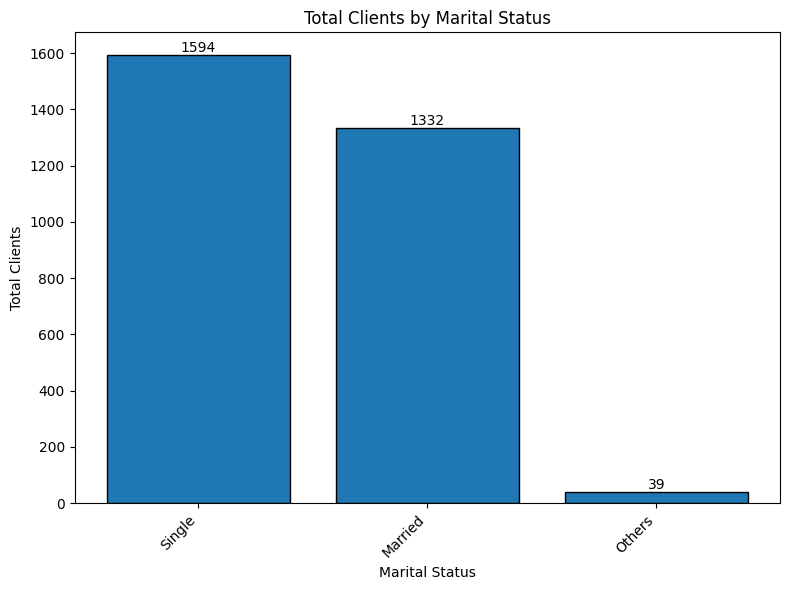

In [13]:
# Replace numerical labels with its name
marital_category = df['marital_status'].replace({
    0: 'Others',
    1: 'Married',
    2: 'Single',
    3: 'Others'
})

# Count the occurrences of each marital category
marital_counts = marital_category.value_counts().sort_values(ascending=False)

# Convert index labels to strings for plotting
x_labels = marital_counts.index.astype(str)
y_values = marital_counts.values

# Plotting the bar graph
plt.figure(figsize=(8, 6))
bars = plt.bar(x_labels, y_values, edgecolor='black')
plt.xlabel('Marital Status')
plt.ylabel('Total Clients')
plt.title('Total Clients by Marital Status')
plt.xticks(rotation=45, ha='right')

# Adding the text labels above the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 1), ha='center', va='bottom')

plt.tight_layout()
plt.show()


The bar chart shows the total number of clients according to their marital status, with X representing the marital status and Y representing the total number of clients. The highest number of clients are single (1594 people), followed by married (1332) and others (39).

From this analysis, it's evident that the majority of clients are unmarried, with singles making up a significant proportion of the company's client base.

#### **iv. Distribution of Age**

Exploring the age distribution of all clients is the next task at hand.

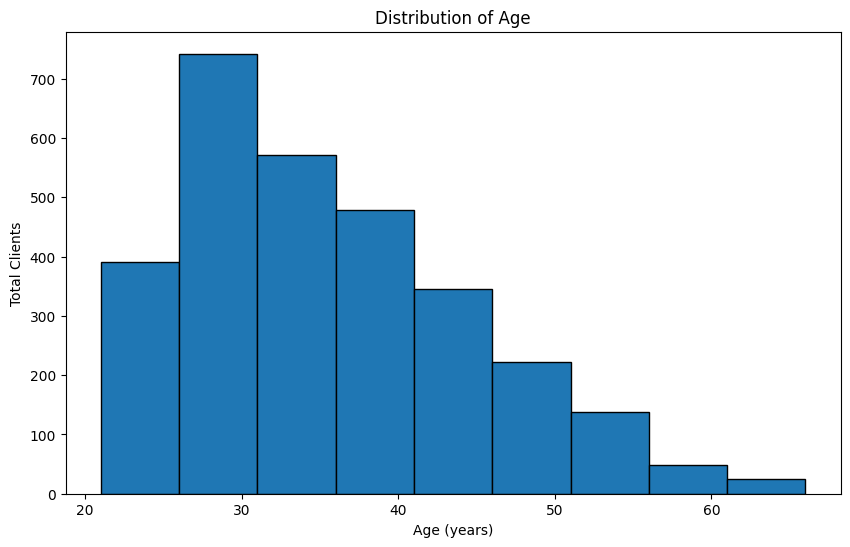

In [14]:
# Plot graph
plt.figure(figsize=(10, 6))
plt.hist(df['age'], bins=range(int(df['age'].min()), int(df['age'].max()) + 1, 5), edgecolor='black')
plt.title('Distribution of Age')
plt.xlabel('Age (years)')
plt.ylabel('Total Clients')
plt.show()


The histogram shows the distribution of clients' age where X represents the age and Y represensts the total clients. It indicates that in the credit default payment dataset, the younger demographic, particularly those between 20 and 30 years old, has the highest frequency of all clients. 

#### **v. Bill Amounts over 6 Months**

Given the columns representing bill amounts from April to September, the next step involves visualizing the trend.

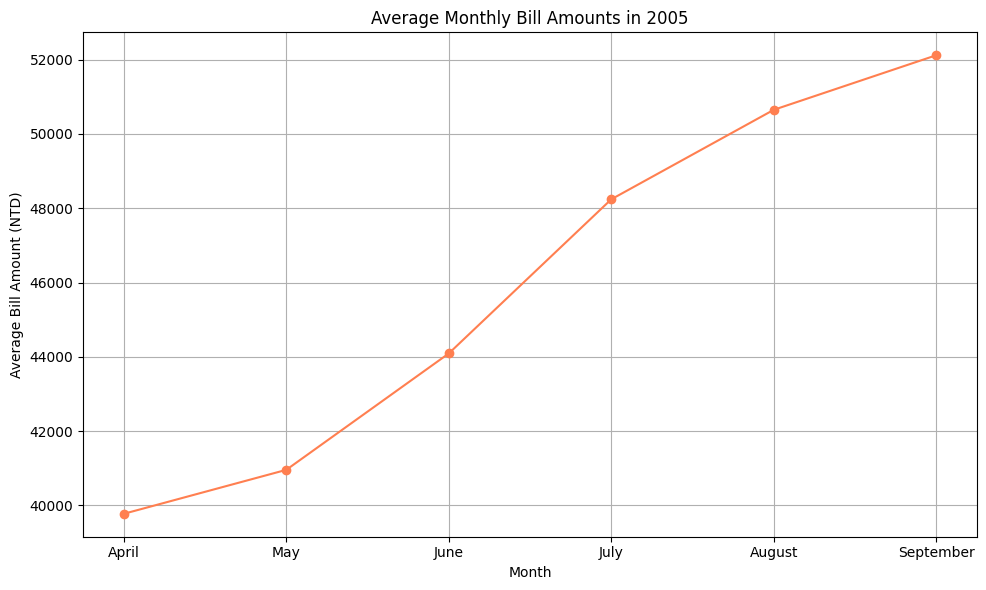

In [15]:
# Rename columns
bill_amount = df.rename(columns={'bill_amt_1': 'September',
                                 'bill_amt_2': 'August',
                                 'bill_amt_3': 'July',
                                 'bill_amt_4': 'June',
                                 'bill_amt_5': 'May',
                                 'bill_amt_6': 'April'})

# Calculate the average of payment status for each month
bill_amounts_avg = bill_amount[['September', 'August', 'July', 'June', 'May', 'April']].mean()

month_label = ['April', 'May', 'June','July', 'August', 'September']
bill_amounts_avg = bill_amounts_avg.reindex(month_label)

# Plotting the line graph
plt.figure(figsize=(10, 6))
plt.plot(bill_amounts_avg.index, bill_amounts_avg.values, marker='o', linestyle='-', color='coral')
plt.title('Average Monthly Bill Amounts in 2005')
plt.xlabel('Month')
plt.ylabel('Average Bill Amount (NTD)')
plt.xticks(ticks=range(len(bill_amounts_avg.index)), labels=bill_amounts_avg.index)
plt.grid(True)
plt.tight_layout()
plt.show()

The line graph shows a clear upward trend in average monthly bill amounts in New Taiwan Dollars (NTD) from April to September in 2005. Starting from a low in April, there is a consistent increase each month, with the highest average bill amount in September. This could suggest a seasonal pattern in spending or bill accumulation, where individuals may have higher expenses towards the end of the year. 

#### **vi. Payment Amounts over 6 Months**

Following the bill amount analysis, the next step is to examine how clients make payments.

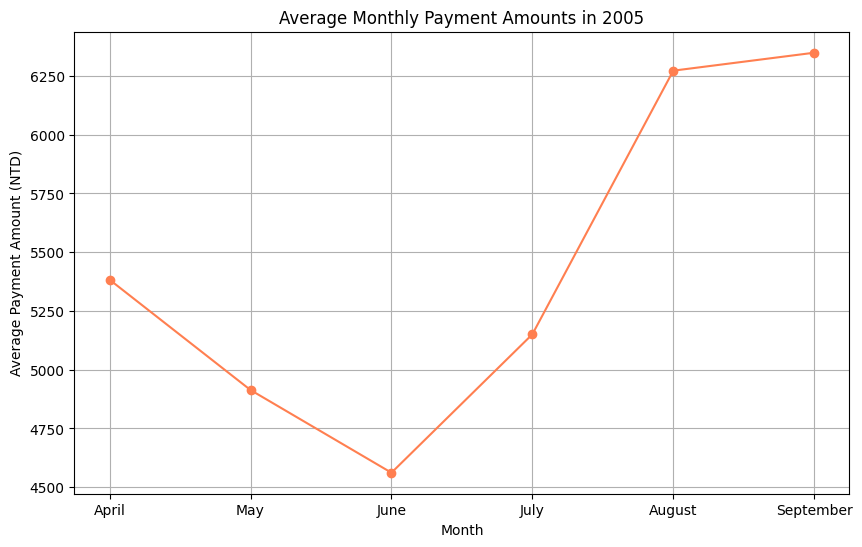

In [16]:
# Define the columns to plot and rename labels
payment = ['pay_amt_6', 'pay_amt_5', 'pay_amt_4', 'pay_amt_3', 'pay_amt_2', 'pay_amt_1']

# Calculate the average payment for each month
monthly_payments = df[payment].mean()

# Create a line plot
plt.figure(figsize=(10, 6))
plt.plot(month_label, monthly_payments, marker='o', linestyle='-', color='coral')
plt.title('Average Monthly Payment Amounts in 2005')
plt.xlabel('Month')
plt.ylabel('Average Payment Amount (NTD)')
plt.grid(True)
plt.show()

The line graph presents a trend in average monthly payment amounts in New Taiwan Dollars (NTD) for the year 2005, which have a little contrasts with the bill amounts trend shared earlier. It started off lower in April, then decreasing further in May and June, before climbing steadily to a peak in September. This pattern may suggest a trend where payments bottom out mid-year and then increase toward the end of the year, possibly as individuals begin to settle accumulated debts or due to an uptick in spending.

#### **vii. Default Payment Percentages**

Lastly, let's take a look at the composition of default and non-default payments.

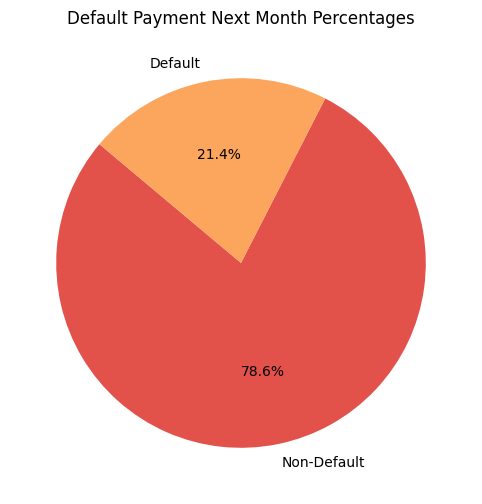

In [17]:
# Replace numerical labels with its name
default_status = df['default_payment_next_month'].replace({1: 'Default',
                                                           0: 'Non-Default'})

# Count the occurrences of default categories
default_counts = default_status.value_counts()

# Calculate the percentage for each default category
default_percentages = (default_counts / default_counts.sum()) * 100

# Plotting the pie chart
plt.figure(figsize=(10, 6))
plt.pie(default_percentages, labels=default_percentages.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette('Spectral'))
plt.title('Default Payment Next Month Percentages')

plt.show()

The pie chart shows how many clients make their payments on time and how many don't. Most clients, about 78.6%, pay on time (non-default). However, around 21.4% don't pay on time (default). This smaller group needs more attention from credit institutions to figure out why they struggle with payments. Learning more about these clients can help improve risk assessment and credit scoring methods.

### **F. Feature Engineering**

Before moving on to model development, the features need to be selected to ensure that only correlated features are used and any irrelevant or redundant features are removed. Additionally, the selected features should be pre-processed to enhance the overall analysis.

#### **i. Split Inference Set**

For model testing or inference purposes, 1 row is taken out of the dataset and saved as a separate CSV file.

In [18]:
# Select 1 row to test as inference set and save it to a variable
data_inf = df.sample(1, random_state=50)

# Delete selected row from dataframe
df.drop(data_inf.index, inplace=True)

# Reset index for both dataframe
df.reset_index(drop=True, inplace=True)
data_inf.reset_index(drop=True, inplace=True)

# Remove target in data_inf
data_inf.drop(['default_payment_next_month'], axis=1, inplace=True)

# Save data_inf to csv
data_inf.to_csv('data_inf.csv')

In the dataset used to develop the model, the row that was extracted is removed to ensure the model isn't trained on that specific data. When preparing the inference dataset, the `default_payment_next_month` column, which is the target variable, is removed to enable accurate model predictions.

#### **ii. Split X (Features) and y (Target)**

Following the separation of the inference set, the remaining dataset is splitted into features and target variables. In this analysis, X represents the features, while y represents the target variable.

In [19]:
# Split between X and y
X = df.drop(['default_payment_next_month'], axis=1)
y = df.default_payment_next_month

X excludes the `default_payment_next_month` column from the dataset, whereas y only includes the `default_payment_next_month` column.

#### **iii. Split Train-Set and Test-Set**

After splitting into X and y, both datasets must now be split again into **training sets** and **testing sets**. The training set will be used to train the model, while the testing set will be used to evaluate the model's performance on unseen data.

In [20]:
# Splitting train-set and test-set using 'Train_test_split'
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)

# Print train and test shape
print('Train Size :', X_train.shape)
print('Test Size :', X_test.shape)

# Show one of the variable 
X_train.head()

Train Size : (2074, 23)
Test Size : (890, 23)


,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_3,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6
1290,130000.0,2,3,1,42.0,2.0,2.0,0.0,0.0,0.0,...,95477.0,95334.0,96066.0,97413.0,0.0,4500.0,3500.0,3400.0,4000.0,4000.0
1911,90000.0,2,2,2,26.0,1.0,2.0,2.0,2.0,2.0,...,53295.0,53826.0,54548.0,55525.0,0.0,5000.0,2000.0,2200.0,2000.0,2500.0
1837,110000.0,1,1,2,30.0,1.0,2.0,2.0,2.0,2.0,...,92035.0,93231.0,94309.0,96258.0,4200.0,4200.0,3600.0,3500.0,3600.0,0.0
2424,160000.0,2,2,2,34.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,7918.0,13780.0,12297.0,12752.0,24000.0,8000.0,13780.0,12300.0,12752.0,6000.0
2405,20000.0,2,2,1,43.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,3898.0,1681.0,901.0,0.0,1291.0,3898.0,1681.0,901.0,0.0,0.0


The training set now consists of **2074** rows, while the test set consists of **890** rows. The splitting method uses `stratify` to ensure that the proportion of 'yes' and 'no' default payments in the target variable (y) is maintained in both the training and testing sets. This helps in creating representative subsets of data for training and evaluation, especially in cases where the target variable is **imbalanced**.

#### **iv. Missing Value Handling**

In the previous exploration, it was concluded that there are no missing values in the dataset. Therefore, this section will simply double check from the 4 variables split before, there are indeed no missing values.

In [21]:
# Check missing value in X_train
X_train.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [22]:
# Check missing value in X_test
X_test.isnull().sum()

limit_balance      0
sex                0
education_level    0
marital_status     0
age                0
pay_0              0
pay_2              0
pay_3              0
pay_4              0
pay_5              0
pay_6              0
bill_amt_1         0
bill_amt_2         0
bill_amt_3         0
bill_amt_4         0
bill_amt_5         0
bill_amt_6         0
pay_amt_1          0
pay_amt_2          0
pay_amt_3          0
pay_amt_4          0
pay_amt_5          0
pay_amt_6          0
dtype: int64

In [23]:
# Check missing value in y_train
y_train.isnull().sum()

0

In [24]:
# Check missing value in y_test
y_test.isnull().sum()

0

It can be seen that among the four variables: **X_train, y_train, X_test, and y_test**, there are no missing values. Hence, moving forward to the next task can be done without any worries regarding missing data.

#### **v. Outlier Handling**

After checking missing values, the outliers need to be checked and handled too. Outliers are data points that differs significantly from the rest of the data, often indicating errors, anomalies, or rare events. Therefore, removing outliers is important to make sure that statistical analyses are not influenced by extreme values, and that the results accurately reflect the patterns in the data.

However, columns with minimal unique values will not be included in this outlier handling process because they may contain important information. Removing such columns could lead to the loss of significant data. Also, categorical columns are not handled in this section (including the encoded). The excluded columns are:
- `sex`
- `educational_level`
- `marital_status`
- `pay_0`
- `pay_2`
- `pay_3`
- `pay_4`
- `pay_5`
- `pay_6` 

Skewness can be an initial indicator of potential outliers, as it reveals the asymmetry in a dataset. The initial step is to calculate the skewness of each column.

In [25]:
# Create function to check skewness
def check_skewness(df, *column_names):
    return {col: df[col].skew() for col in column_names if col in df.columns}

# Calculate skewness of all numeric columns
skewness_results = check_skewness(X_train, 'limit_balance', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5',
                                  'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6')

# Print skewness
for col, skewness in skewness_results.items():
    print(f"{col}: {skewness}")

limit_balance: 0.9767322252536402
age: 0.7555371953398131
bill_amt_1: 2.4515052150872694
bill_amt_2: 2.413709814532329
bill_amt_3: 2.4462014596449535
bill_amt_4: 2.418609886734928
bill_amt_5: 2.329953330080685
bill_amt_6: 2.3633792584650233
pay_amt_1: 13.589196995565095
pay_amt_2: 32.120888714040916
pay_amt_3: 8.1320349997833
pay_amt_4: 8.224303711378116
pay_amt_5: 12.070223721755609
pay_amt_6: 10.401367170191051


After calculating the skewness for each column, they will be categorized based on their values as follows:

- `Normal columns`: Columns with skewness between -0.5 and 0.5.
- `Skewed columns`: Columns with skewness less than or equal to -1 or greater than or equal to 1.
- `Extremely skewed columns`: Columns with skewness less than -1 or greater than 1.

This categorization helps identify the degree of asymmetry in each column's distribution, allowing for targeted outlier detection and handling strategies.

In [26]:
# Initialize empty lists for each skewness category
normal_columns = []
skewed_columns = []
extreme_skewed_columns = []

# Loop through the skewness values and categorize the columns
for col, skewness in skewness_results.items():
    if skewness < -1.0 or skewness > 1.0:
        extreme_skewed_columns.append(col)
    elif abs(skewness) <= 0.5:
        normal_columns.append(col)
    else:
        skewed_columns.append(col)

# Print the columns in each category
print(f"Normal: {normal_columns}\nSkewed: {skewed_columns}\nExtreme Skewed: {extreme_skewed_columns}")

Normal: []
Skewed: ['limit_balance', 'age']
Extreme Skewed: ['bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']


The columns have been categorized based on their skewness, and no normal columns were found. To calculate the percentages of outliers more efficiently, a function will be used. Since only skewed and extremely skewed columns remain, outliers will be counted using the Interquartile Range (IQR) method.

In [27]:
# Create function to calculate outlier percentages
def calculate_outlier_percentages(df, columns, distance):
    for variable in columns:
        IQR = df[variable].quantile(0.75) - df[variable].quantile(0.25)
        lower_boundary = df[variable].quantile(0.25) - (IQR * distance)
        upper_boundary = df[variable].quantile(0.75) + (IQR * distance)

        outliers = df[(df[variable] < lower_boundary) | (df[variable] > upper_boundary)]
        outlier_percentage = len(outliers) / len(df) * 100
        
        print('Percentage of outliers in {}: {:.2f}%'.format(variable, outlier_percentage))

# Calcuate outlier percentages before handling
calculate_outlier_percentages(X_train, skewed_columns, 1.5)
calculate_outlier_percentages(X_train, extreme_skewed_columns, 3)

Percentage of outliers in limit_balance: 0.39%
Percentage of outliers in age: 0.92%
Percentage of outliers in bill_amt_1: 2.56%
Percentage of outliers in bill_amt_2: 2.41%
Percentage of outliers in bill_amt_3: 2.70%
Percentage of outliers in bill_amt_4: 2.41%
Percentage of outliers in bill_amt_5: 2.36%
Percentage of outliers in bill_amt_6: 2.17%
Percentage of outliers in pay_amt_1: 4.97%
Percentage of outliers in pay_amt_2: 5.88%
Percentage of outliers in pay_amt_3: 5.45%
Percentage of outliers in pay_amt_4: 4.68%
Percentage of outliers in pay_amt_5: 4.77%
Percentage of outliers in pay_amt_6: 5.98%


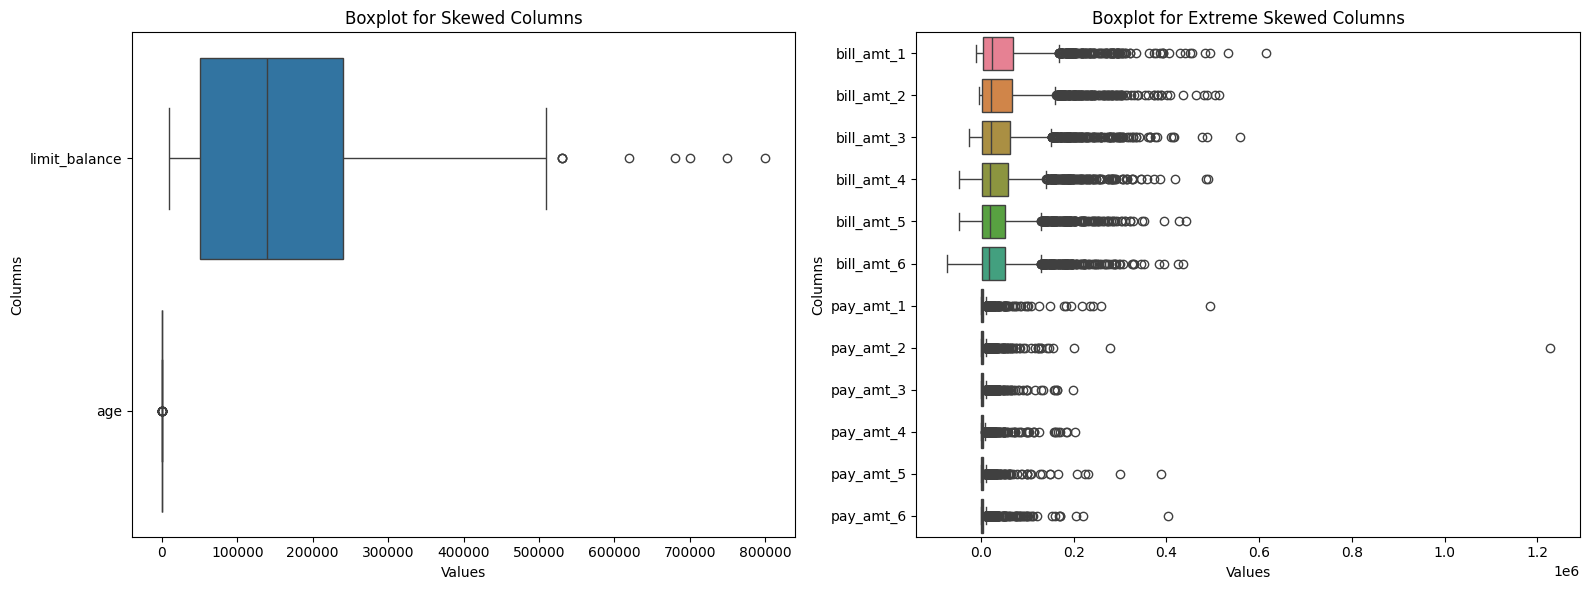

In [28]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for skewed columns
sns.boxplot(data=X_train[skewed_columns], orient="h", ax=axes[0])
axes[0].set_title("Boxplot for Skewed Columns")
axes[0].set_xlabel("Values")
axes[0].set_ylabel("Columns")

# Boxplot for extreme skewed columns
sns.boxplot(data=X_train[extreme_skewed_columns], orient="h", ax=axes[1])
axes[1].set_title("Boxplot for Extreme Skewed Columns")
axes[1].set_xlabel("Values")
axes[1].set_ylabel("Columns")

# Display the plot
plt.tight_layout()
plt.show()

It's concluded that each column still contains outliers, ranging from approximately 0.10% to 6.12%. It also displayed in the boxplot above that there are still some outliers in each column, represented by the circles outside of range. Therefore, it's necessary to handle these outliers. 

The chosen method for handling outliers is **capping** using the **Winsorization** method. This approach avoids dropping rows since the dataset has **limited entries**, and each data point is valuable. Additionally, the outliers are not a result of input errors but rather reflect real data.

[Ref](https://towardsdatascience.com/dont-throw-away-your-outliers-c37e1ab0ce19)

In [29]:
# Create function to apply winsorization
def apply_winsorization(train, variables, capping_method='iqr', tail='both', fold=3):
    winsoriser = Winsorizer(capping_method=capping_method, tail=tail, fold=fold, variables=variables)
    train_capped = winsoriser.fit_transform(train)
    return train_capped

# Apply to X_train column
X_train = apply_winsorization(X_train, skewed_columns, fold=1.5)
X_train = apply_winsorization(X_train, extreme_skewed_columns)

Winsorization is being applied to the `X_train` dataset, taking into account the skewness of its columns. Skewed columns are adjusted using a fold of 1.5, while extremely skewed columns are adjusted using a fold of 3. This approach ensures that outliers are appropriately handled based on the level of skewness observed in each column.

In [30]:
# Check the outliers after handling
calculate_outlier_percentages(X_train, skewed_columns, 1.5)
calculate_outlier_percentages(X_train, extreme_skewed_columns, 3)

Percentage of outliers in limit_balance: 0.00%
Percentage of outliers in age: 0.00%
Percentage of outliers in bill_amt_1: 0.00%
Percentage of outliers in bill_amt_2: 0.00%
Percentage of outliers in bill_amt_3: 0.00%
Percentage of outliers in bill_amt_4: 0.00%
Percentage of outliers in bill_amt_5: 0.00%
Percentage of outliers in bill_amt_6: 0.00%
Percentage of outliers in pay_amt_1: 0.00%
Percentage of outliers in pay_amt_2: 0.00%
Percentage of outliers in pay_amt_3: 0.00%
Percentage of outliers in pay_amt_4: 0.00%
Percentage of outliers in pay_amt_5: 0.00%
Percentage of outliers in pay_amt_6: 0.00%


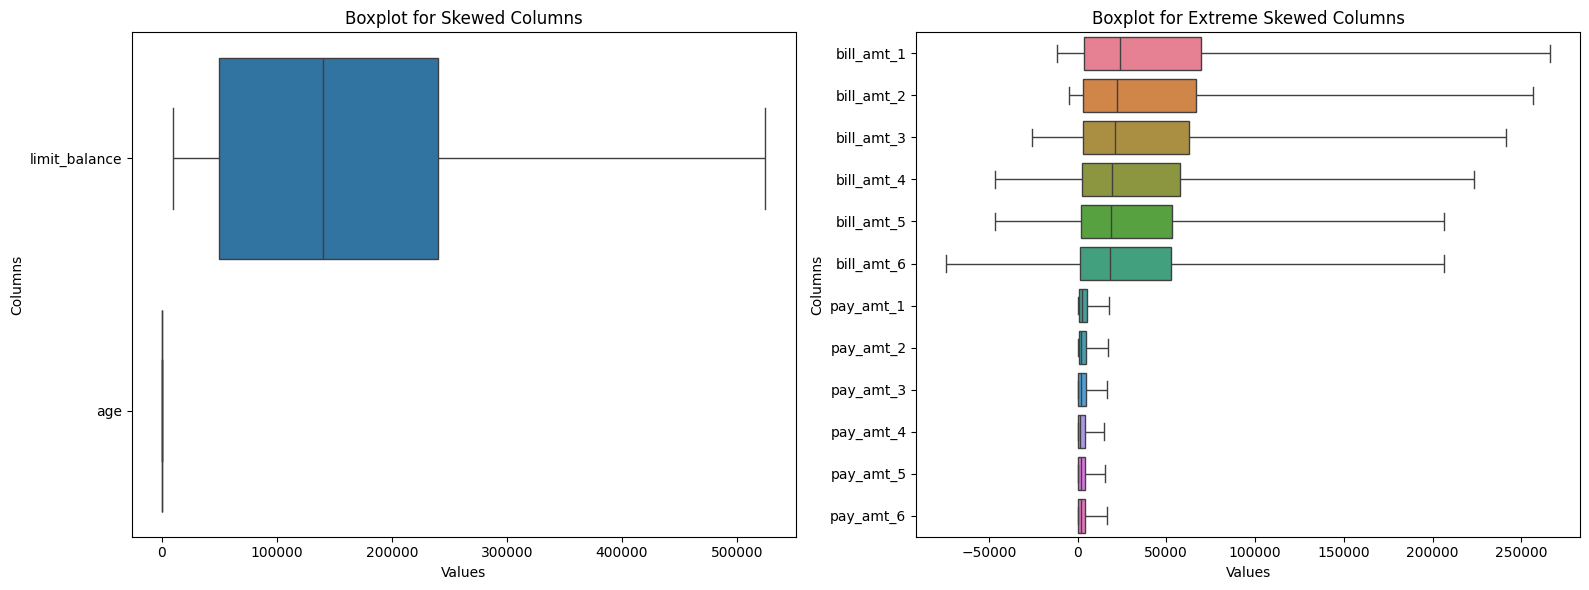

In [31]:
# Create a figure and two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Boxplot for skewed columns
sns.boxplot(data=X_train[skewed_columns], orient="h", ax=axes[0])
axes[0].set_title("Boxplot for Skewed Columns")
axes[0].set_xlabel("Values")
axes[0].set_ylabel("Columns")

# Boxplot for extreme skewed columns
sns.boxplot(data=X_train[extreme_skewed_columns], orient="h", whis=3, ax=axes[1])
axes[1].set_title("Boxplot for Extreme Skewed Columns")
axes[1].set_xlabel("Values")
axes[1].set_ylabel("Columns")

# Display the plot
plt.tight_layout()
plt.show()


After handling the outliers, the percentages are recalculated to ensure that the outliers have indeed been addressed. The updated results show that the percentages of outliers are now all **0**, indicating that the outliers have been effectively handled. The boxplot above strengthens this observation by illustrating that there are no outliers present in the data anymore. This confirms that the outlier handling process was successful.

#### **vi. Feature Selection**

Handling outliers is followed by the feature selection process, which involves exploring variables that correlate with the target variables. This step aims to identify the most relevant features for predicting or understanding the target variables, streamlining the model by focusing on impactful features and removes the less influential ones.

The first step is to concatenate `X_train` and `y_train`, enabling the determination of correlation between the target variables and the features.

In [32]:
# Concatenate X_train and y_train
concat_train = pd.concat([X_train, y_train], axis=1)

# Show X_train
concat_train.head()

,limit_balance,sex,education_level,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,...,bill_amt_4,bill_amt_5,bill_amt_6,pay_amt_1,pay_amt_2,pay_amt_3,pay_amt_4,pay_amt_5,pay_amt_6,default_payment_next_month
1290,130000.0,2,3,1,42.0,2.0,2.0,0.0,0.0,0.0,...,95334.0,96066.0,97413.0,0.0,4500.0,3500.0,3400.0,4000.0,4000.0,1
1911,90000.0,2,2,2,26.0,1.0,2.0,2.0,2.0,2.0,...,53826.0,54548.0,55525.0,0.0,5000.0,2000.0,2200.0,2000.0,2500.0,0
1837,110000.0,1,1,2,30.0,1.0,2.0,2.0,2.0,2.0,...,93231.0,94309.0,96258.0,4200.0,4200.0,3600.0,3500.0,3600.0,0.0,0
2424,160000.0,2,2,2,34.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,13780.0,12297.0,12752.0,17663.5,8000.0,13780.0,12300.0,12752.0,6000.0,0
2405,20000.0,2,2,1,43.0,-1.0,-1.0,-1.0,-1.0,-1.0,...,1681.0,901.0,0.0,1291.0,3898.0,1681.0,901.0,0.0,0.0,0


The `concat_train` now contains both the features and the target variables. Next, a function is created to calculate the Phi-K correlation of all features with `default_payment_next_month`. The Phi-K Matrix is chosen as it's capable of detemining correlations for both numerical and categorical columns.

In [33]:
# Create function to correlate variables with default
def compute_phik_correlation(dataframe, columns):
    subset = dataframe[columns]
    correlation_matrix = subset.phik_matrix()
    return correlation_matrix['default_payment_next_month']

# Define the list of columns for each subset
columns = ['default_payment_next_month', 'limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3',
           'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1',
           'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']

# Compute Phi-K correlation for each set of columns and print
correlation = compute_phik_correlation(concat_train, columns)

# Print result
print(correlation)

interval columns not set, guessing: ['default_payment_next_month', 'limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4', 'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6']
default_payment_next_month    1.000000
limit_balance                 0.205996
sex                           0.000000
education_level               0.072701
marital_status                0.000000
age                           0.000000
pay_0                         0.479321
pay_2                         0.472448
pay_3                         0.330615
pay_4                         0.401105
pay_5                         0.380475
pay_6                         0.350769
bill_amt_1                    0.062714
bill_amt_2                    0.049165
bill_amt_3                    0.000000
bill_amt_4                    0.000000
bill_amt_5               

The results display the correlation between all features and `default_payment_next_month`, with values ranging from 0 to 1. A value of 1 indicates a strong correlation, while 0 indicates no correlation. The chosen threshold for this analysis is **0.3**. Therefore, only variables with correlation values greater than 0.3 are considered to have a meaningful correlation with the target variable. Based on the result, the features that exhibit correlation are:

- `pay_0`
- `pay_2`
- `pay_3`
- `pay_4`
- `pay_5`
- `pay_6`

These features show some level of association with `default_payment_next_month` and may be considered important for predicting or understanding the target variable.

In [34]:
# Drop unnecessary columns in X_train
X_train.drop(['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4',
              'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1,  inplace=True)

# # Drop unnecessary columns in X_test
X_test.drop(['limit_balance', 'sex', 'education_level', 'marital_status', 'age', 'bill_amt_1', 'bill_amt_2', 'bill_amt_3', 'bill_amt_4',
             'bill_amt_5', 'bill_amt_6', 'pay_amt_1', 'pay_amt_2', 'pay_amt_3', 'pay_amt_4', 'pay_amt_5', 'pay_amt_6'], axis=1,  inplace=True)

The columns with no correlation is dropped from both `X_train` and `X_test`.

In [35]:
# Show columns
print(X_train.columns)
print(X_test.columns)

Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')
Index(['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6'], dtype='object')


The `X_train` and `X_test` variables are now consist of the columns with correlation to `default_payment_next_month`.

#### **vii. Split Numerical and Categorical Columns**

The selected features are split into their data categorizations as defined in the previous section.

In [36]:
# Split numerical and categorical columns

cat_encoded_ordinal = ['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']

print(f'Categorical ordinal columns:\n{cat_encoded_ordinal}')

Categorical ordinal columns:
['pay_0', 'pay_2', 'pay_3', 'pay_4', 'pay_5', 'pay_6']


There is only one type of data which is categorical encoded ordinal.

#### **vii. Cardinality Check**

The cardinality check is performed to determine whether the categorical columns have low or high cardinality. High cardinality columns need to be handled by splitting them into smaller groups to avoid bias in the Machine Learning process.

In [37]:
# Check number of unique values in categorical columns

print('Number of categories in the variable Pay 0  : {}'.format((X_train.pay_0.nunique())))
print('Number of categories in the variable Pay 2  : {}'.format((X_train.pay_2.nunique())))
print('Number of categories in the variable Pay 3  : {}'.format((X_train.pay_3.nunique())))
print('Number of categories in the variable Pay 4  : {}'.format((X_train.pay_4.nunique())))
print('Number of categories in the variable Pay 5  : {}'.format((X_train.pay_5.nunique())))
print('Number of categories in the variable Pay 6  : {}'.format((X_train.pay_6.nunique())))

Number of categories in the variable Pay 0  : 10
Number of categories in the variable Pay 2  : 10
Number of categories in the variable Pay 3  : 9
Number of categories in the variable Pay 4  : 9
Number of categories in the variable Pay 5  : 8
Number of categories in the variable Pay 6  : 8


However, all the columns have **low cardinality** (<11), indicating that there's no need to categorize them into smaller groups.

#### **viii. Feature Scaling and Encoding**

Since the categorical columns are already encoded, there's **no need** to perform encoding in this step and since there are no numerical columns in the selected features, there's also **no need** to perform scaling in this step.

In [38]:
# Preprocessing using ColumnTransformer

preprocess = ColumnTransformer(transformers=[],
                               remainder='passthrough')

The code above uses `ColumnTransformer` to perform transformations on the dataset. However, because scalers and encoders are not utilized in this analysis, the transformers are left empty. The categorical encoded columns are passed through the preprocessing stage using the `remainder='passthrough'` parameter.

### **G. Model Definition**

After completing the pre-processing steps, the next task is to define the models that will be used for training. For this analysis, the chosen models are `K-Nearest Neighbors (KNN)`, `Support Vector Machine (SVM)`, and `Logistic Regression`.

1. **K-Nearest Neighbors (KNN):**
   - KNN is effective when there are clear clusters or patterns in the data. For credit card default prediction, it can be useful because customers who default may share similarities in spending habits, payment history, or other financial behaviors. KNN works by assigning a new data point to the class most common among its k nearest neighbors, making it potentially suitable for identifying similar credit card users who are likely to default.

2. **Support Vector Machine (SVM):**
   - SVMs are good at handling complex data relationships and can work well even when the data is not linearly separable. In the context of credit card default prediction, SVMs can be beneficial because they can capture non-linear relationships between features like sex, age,  limit balance, and default probability. SVMs aim to find the optimal hyperplane that separates different classes with the maximum margin, making them robust for classification tasks with intricate decision boundaries.

3. **Logistic Regression:**
   - Logistic Regression is a popular choice for binary classification problems like credit card default prediction. It's straightforward to interpret, provides probabilities of class membership, and is less prone to overfitting, especially with a large number of features. In credit risk analysis, logistic regression can be advantageous for modeling the probability of default based on various factors like limit balance, payment history, etc. Its simplicity and interpretability make it a valuable tool in understanding the factors influencing credit card defaults.

For this analysis, the scoring primarily focuses on **Recall**. This decision is driven by the objective of creating a model capable of predicting default payments next month. It is crucial to minimize False Negatives, i.e., cases where the model predicts non-default but the actual outcome is default. Therefore, to prioritize minimizing False Negatives, Recall is emphasized more than Precision. 

While aiming for a higher Recall can lead to a lower Precision due to an increase in False Positives (misclassifying non-defaulters as defaulters), this tradeoff is inherent and unavoidable. A higher False Positive rate means more individuals will be incorrectly labeled as defaulters, which may inconvenience them. However, whether this tradeoff is justifiable depends on the business goals and desired accuracy level. In this case, prioritizing a higher Recall to catch more defaulters is preferred, even if it comes at the cost of a lower Precision.

[Ref](https://towardsdatascience.com/catching-a-welcher-classifying-a-credit-card-defaulter-f4b21547a618)

During this stage, a Pipeline is used to streamline the further processes. The variables are stored in a pipeline using `make_pipeline`, which includes the preprocess step and the chosen model.

In [39]:
# Model definition using Pipeline
pipe_knn = make_pipeline(preprocess, KNeighborsClassifier())
pipe_svc = make_pipeline(preprocess, SVC())
pipe_log = make_pipeline(preprocess, LogisticRegression())

### **H. Model Training**

The model is then trained using **Cross Validation** to help mitigate issues like data leakage. Cross-validation during training splitted the data into multiple subsets (folds). The model is trained on 𝑘 (1 fold) and validated on the remaining fold, and this process is repeated 𝑘 times (where 𝑘 is the number of folds). It helps to minimize data leakage because each fold is treated as an independent test set during one iteration of the training process. 

In [40]:
# Training using Cross Validation
cv_knn = cross_val_score(pipe_knn, X_train, y_train, cv=5, scoring='recall', n_jobs=-1) 
cv_svc = cross_val_score(pipe_svc, X_train, y_train, cv=5, scoring='recall', n_jobs=-1) 
cv_log = cross_val_score(pipe_log, X_train, y_train, cv=5, scoring='recall', n_jobs=-1)

In each model, Cross Validation is performed using `X_train` and `y_train` with cv=5, where CV represents Cross Validation and k denotes the number of folds. Therefore, the training dataset is divided into 5 subsets, and the training process iterates until achieving the best score.

### **I. Model Evaluation**

This section focuses on evaluating the created model, which includes three parts:
- **Cross Validation Evaluation**: Identifying the best model among the three models after cross validation.
- **Best Model Evaluation**: Fitting the best model to the training and testing sets.
- **Hyperparameter Tuning**: Determining the optimal hyperparameters for the best model.

#### **i. Cross Validation Evaluation**

In the Cross Validation Evaluation, the performance of the three models is compared. The best model is selected based on the mean score obtained from the 5 cross-validations, where the calculated scores are averaged.

In [41]:
model = []
cv_score = 0

for cv, name in zip([cv_log, cv_svc, cv_knn],
                    ['Logistic Regression', 'SVC', 'KNN']):
    print(name)
    print('Recall - All - Cross Validation', cv)
    print('Recall - Mean - Cross Validation', cv.mean())
    print('-'*50)
    if cv.mean() > cv_score:
        cv_score = cv.mean()
        model = name
    else:
        pass
    
print('Best Model:', model)
print('Cross Validation Mean from Best Model:', cv_score)

Logistic Regression
Recall - All - Cross Validation [0.34831461 0.35955056 0.23595506 0.24719101 0.35227273]
Recall - Mean - Cross Validation 0.3086567926455567
--------------------------------------------------
SVC
Recall - All - Cross Validation [0.39325843 0.43820225 0.33707865 0.40449438 0.36363636]
Recall - Mean - Cross Validation 0.38733401430030645
--------------------------------------------------
KNN
Recall - All - Cross Validation [0.53932584 0.33707865 0.24719101 0.42696629 0.36363636]
Recall - Mean - Cross Validation 0.3828396322778345
--------------------------------------------------
Best Model: SVC
Cross Validation Mean from Best Model: 0.38733401430030645


The output displays reports for the three models. Among them, SVC has the highest mean cross-validation score of 0.38733, followed by KNN with 0.38283, and lastly Logistic Regression with 0.30865. Based on these results, the model selected for further analysis will be **SVC**.

#### **ii. Best Model Evaluation**

The next step involves evaluating the previously selected model, which is the SVC model. This model will be trained using `X_train` and `y_train`.

In [42]:
# Fit pipeline on the training data
pipe_svc.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough', transformers=[])),
                ('svc', SVC())])

In [43]:
# Get predictions for both training and test data
y_pred_train = pipe_svc.predict(X_train)
y_pred_test = pipe_svc.predict(X_test)

In [44]:
# Print recall score
print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train))
print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test))

Recall Score - Train Set  :  0.43018018018018017
Recall Score - Test Set   :  0.4397905759162304


The Recall scores for the train and test sets are **0.43018** and **0.43979**, respectively. These scores are far from the highest possible score of 1, which indicates an **under fit** for the model. However, the relatively close scores between the train set and test set suggest that the model is generalized and capable of making accurate predictions on unseen data.

To evaluate further, the confusion matrix is used to display the amount of True Positive, True Negative, False Positive, and False Negative.

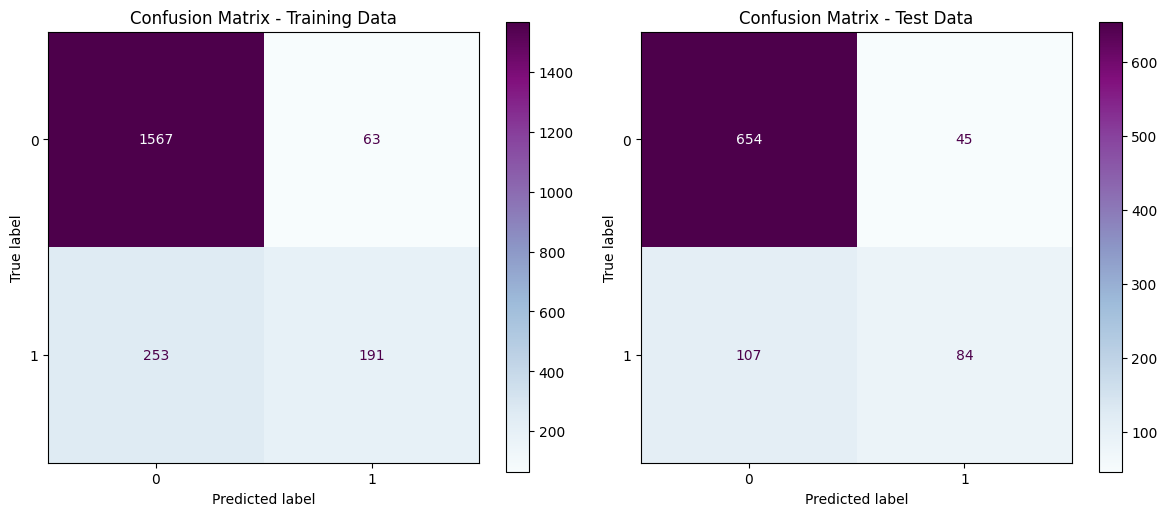

In [45]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix = ConfusionMatrixDisplay.from_estimator(pipe_svc, X_train, y_train, cmap='BuPu', ax=axes[0])
train_matrix.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix = ConfusionMatrixDisplay.from_estimator(pipe_svc, X_test, y_test, cmap='BuPu', ax=axes[1])
test_matrix.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

**1. Training Data Confusion Matrix:**
- True Positives (TP): 191 - The model correctly predicted the default class (yes).
- True Negatives (TN): 1567 - The model correctly predicted the non-default class (no).
- False Positives (FP): 63 - The model incorrectly predicted the default class (yes) when it was actually non-default.
- False Negatives (FN): 253 - The model incorrectly predicted the non-default class (no) when it was actually default.

**2. Test Data Confusion Matrix:**
- True Positives (TP): 84 - The model correctly predicted the default class (yes).
- True Negatives (TN): 654 - The model correctly predicted the non-default class (no).
- False Positives (FP): 45 - The model incorrectly predicted the default class (yes) when it was actually non-default.
- False Negatives (FN): 107 - The model incorrectly predicted the non-default class (no) when it was actually default.

The model didn't significantly reduce false negatives, as they still remain a substantial portion of the predictions, which could be risky depending on the situation. For instance, in credit risk, missing a default can be more costly than wrongly flagging a non-default. Having false positives and negatives indicates there's space for improving the model, maybe through **hyperparameter tuning**.

In [46]:
# Create function to create reports
def performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, name):
    # Calculate recall scores
    score_reports = {
        'Recall Train Set': recall_score(y_train, y_pred_train),
        'Recall Test Set': recall_score(y_test, y_pred_test),
    }
    
    # Calculate confusion matrices for train and test sets
    cm_train = confusion_matrix(y_train, y_pred_train)
    cm_test = confusion_matrix(y_test, y_pred_test)
    
    # Extract false negatives from the confusion matrices and add to the report
    score_reports['False Negative Train'] = cm_train[1, 0]
    score_reports['False Negative Test'] = cm_test[1, 0]
    
    # Store the report in the dictionary with the specified model name
    all_reports[name] = score_reports
    return all_reports

all_reports = {}
all_reports = performance_report(all_reports, y_train, y_pred_train, y_test, y_pred_test, 'SVM without Tuning')

pd.DataFrame(all_reports)

,SVM without Tuning
Recall Train Set,0.430180
Recall Test Set,0.439791
False Negative Train,253.000000
False Negative Test,107.000000


The SVM model before tuning shows a recall of about 0.43 for both training and test sets, meaning it correctly identifies 43% of actual defaults. This low recall rate could be a problem in situations where missing defaults is serious, like in finance.

Also, the model has a lot of false negatives, 253 in training and 107 in testing, meaning it predicts non-defaults when it's actually default. This shows the model tends to play it safe in predicting defaults. The similar recall and false negatives in both sets mean the model is consistent, but it could improve with tuning to better find defaults.

#### **iii. Hyperparameter Tuning**

Since the model still needs some improvements, the next step involves hyperparameter tuning for the SVC model. Four parameters are targeted for tuning: C, gamma, kernel, and class weight, each chosen for specific reasons:

- **C**: Reflects the regularization strength; lower values lead to stronger regularization, penalizing misclassifications more heavily, while higher values allow for more flexible decision boundaries but may risk overfitting.
  
- **Gamma**: Influences the impact of a single training example; smaller values widen the influence radius for support vectors, resulting in smoother decision boundaries, whereas larger values create more intricate boundaries.
  
- **Kernel**: Determines the kernel type used in the SVM algorithm, significantly affecting the decision boundary's shape and the model's capability to capture complex data relationships.
  
- **Class Weight**: Addresses class imbalance by assigning varying weights to different classes, crucial for datasets where one class significantly outnumbers others, ensuring better performance for minority classes.

To optimize these parameters, Grid Search technique is applied, exploring different hyperparameter combinations for improved model performance.

In [47]:
# Set up the parameter grid
param_grid = {
    'svc__C': [0.1, 1], 
    'svc__gamma': [0.001, 0.0001, 'scale', 'auto'],
    'svc__kernel': ['linear', 'rbf', 'sigmoid'],
    'svc__class_weight': [None, 'balanced']
}

# Set up the GridSearchCV object
grid_search = GridSearchCV(pipe_svc,
                           param_grid=param_grid,
                           scoring='recall',
                           cv=5,
                           verbose=2,
                           n_jobs=-1)

# Fit GridSearchCV
grid_search.fit(X_train, y_train)

# Best hyperparameters
print('Best hyperparameters:', grid_search.best_params_)

# Best recall
print('Best recall:', grid_search.best_score_)

# Save best model to a variale
best_svm = grid_search.best_estimator_

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best hyperparameters: {'svc__C': 0.1, 'svc__class_weight': 'balanced', 'svc__gamma': 'auto', 'svc__kernel': 'rbf'}
Best recall: 0.6260725229826354


After thorough exploration of SVC parameters, the optimal settings were identified and saved as `best_svm`. These best hyperparameters are:
- C: 0.1
- Class Weight: balanced
- Gamma: auto
- Kernel: rbf

This configuration resulted the best recall score of **0.62607**. This outcome suggests that the model, with these specific settings, is proficient at correctly identifying default payment next month, reducing the instances where defaults are missed (False Negatives). The 'balanced' class weight ensures fair treatment for all classes, especially crucial in scenarios with imbalanced datasets. Overall, these insights demonstrate the effectiveness of the hyperparameter tuning process in optimizing model performance for the task at hand.

In [48]:
# Get predictions for training and testing set using the hyperparameter tuned model
y_pred_train_tuned = best_svm.predict(X_train)
y_pred_test_tuned = best_svm.predict(X_test)

In [49]:
# Show result after hyperparameter tuning
print('Recall Score - Train Set  : ', recall_score(y_train, y_pred_train_tuned))
print('Recall Score - Test Set   : ', recall_score(y_test, y_pred_test_tuned))

Recall Score - Train Set  :  0.6486486486486487
Recall Score - Test Set   :  0.6387434554973822


After hyperparameter tuning, the recall score increased significantly, with the training score reaching **0.64864** and the testing score at **0.63874**. This marked improvement from the scores without tuning indicates that the hyperparameter tuning process **successfully** enhanced the model's performance. Even though the model is remained **underfit** (< 0.7), it still show improvements from the base model. 

Next, the confusion matrix will be displayed for both the training and testing sets to assess any reduction in False Negatives.

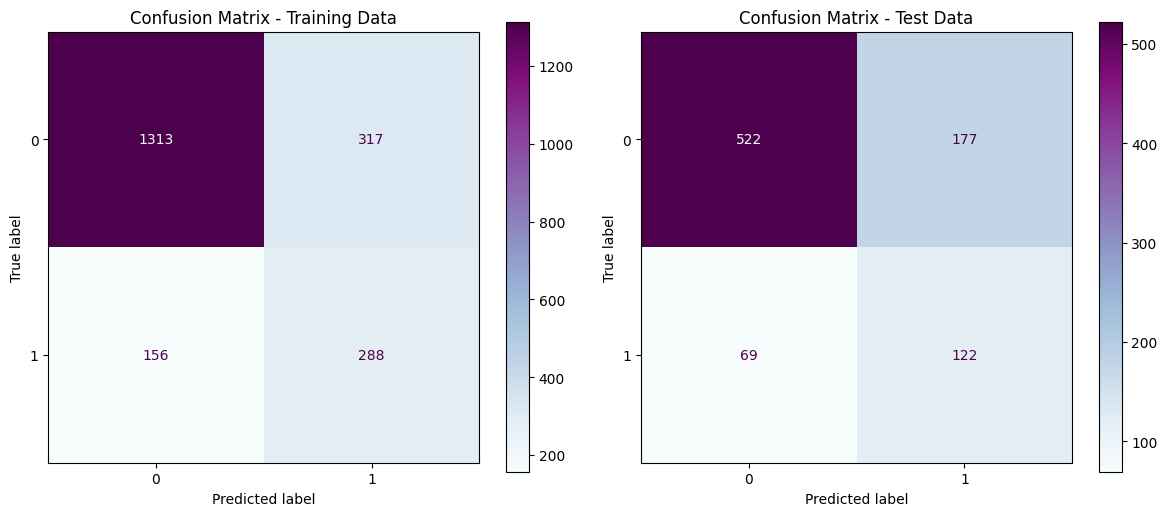

In [50]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot confusion matrix for training data
train_matrix_tuned = ConfusionMatrixDisplay.from_estimator(best_svm, X_train, y_train, cmap='BuPu', ax=axes[0])
train_matrix_tuned.ax_.set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for test data
test_matrix_tuned = ConfusionMatrixDisplay.from_estimator(best_svm, X_test, y_test, cmap='BuPu', ax=axes[1])
test_matrix_tuned.ax_.set_title('Confusion Matrix - Test Data')

plt.tight_layout()
plt.show()

**1. Training Data Confusion Matrix:**
- True Positives (TP): 288 - The model correctly predicted the default class (yes).
- True Negatives (TN): 1313 - The model correctly predicted the non-default class (no).
- False Positives (FP): 317 - The model incorrectly predicted the default class (yes) when it was actually non-default.
- False Negatives (FN): 156 - The model incorrectly predicted the non-default class (no) when it was actually default.

**2. Test Data Confusion Matrix:**
- True Positives (TP): 122 - The model correctly predicted the default class (yes).
- True Negatives (TN): 522 - The model correctly predicted the non-default class (no).
- False Positives (FP): 177 - The model incorrectly predicted the default class (yes) when it was actually non-default.
- False Negatives (FN): 69 - The model incorrectly predicted the non-default class (no) when it was actually default.

The hyperparameter tuning improved the confusion matrix, with False Negatives decreasing to 156 in the training set and to 69 in the testing set. Despite an increase in precision, this improvement comes with an undeniable trade-off. However, given the analysis's emphasis on Recall, the increase in precision is acceptable and does not significantly impact the overall objective.

In [51]:
# Add results to the previous table
all_reports = performance_report(all_reports, y_train, y_pred_train_tuned, y_test, y_pred_test_tuned, 'SVM with Tuning')
pd.DataFrame(all_reports)

,SVM without Tuning,SVM with Tuning
Recall Train Set,0.430180,0.648649
Recall Test Set,0.439791,0.638743
False Negative Train,253.000000,156.000000
False Negative Test,107.000000,69.000000


After tuning the SVM model, it showed significant enhancement in its capability to detect false negatives, indicating a stronger ability to correctly identify positive instances. This improvement suggests that the tuned model has optimized its settings to perform well not only on the training data but also on new, unseen data, implying a reduced risk of overfitting.

### **J. Model Saving**

Once the model is tuned, it is saved as a .pkl file, especially when using a Pipeline. This keeps everything, like preprocessing steps and the tuned model, together in one place, making it simpler to use the model.

In [52]:
# Save the best model
with open('best_svm_model.pkl', 'wb') as model_file:
  pickle.dump(best_svm, model_file)

### **K. Model Inference**

This section will be performed in a separate file named **'P1G5_Set_1_livia_amanda_inference.ipynb'**.

### **L. Conceptual Problems**

#### **i. Coefficients in Logistic Regression**

Coefficients in Logistic Regression represents the **weight** of each features that can influence the y or target variable. They determine the importance or contribution of each feature to the predicted outcome. Just as heavier weights in a physical balance scale tilt it more strongly in one direction, larger coefficients in logistic regression indicate a stronger influence of that feature on the predicted outcome.

The main difference between coefficients in Linear and Logistic Regression is the type of dependent variable each handles. Linear regression deals with **continuous** dependent variables, while logistic regression deals with **binary or categorical** dependent variables. The coefficients in linear regression represent the change in the dependent variable, while in logistic regression, they represent the log odds of the dependent variable being in one category compared to another.

#### **ii. Kernel in SVM**

In Support Vector Machines (SVM), the kernel is a crucial parameter that helps the algorithm handle data. It essentially transforms data into a higher dimensional space where it might be easier to separate using a linear boundary.

1. **Transforming Data**: The kernel function lifts the data into a higher dimension where separating groups with a straight line or smooth curve becomes feasible, even if it’s not possible in the original space.

2. **Types of Kernels**:

   - **Linear Kernel**:  
      Directly uses the original features to find a separating hyperplane. It's effective when the data is linearly separable in the original feature space.

   - **Polynomial Kernel**:  
      This kernel raises the data points to higher degrees by the specified degree of the kernel. For example, with a degree of 2, every data point of x is transformed by squaring it to \( x^2 \) to create a more complex feature map that can capture interactions between original features. This is beneficial for data that isn't linearly separable but can be managed with a polynomial division.

   - **Radial Basis Function (RBF)**:  
      It transforms the data points such that the influence of a single data point decreases with distance from it, forming a sort of influence map. It has infinite number of dimension. More dimension means that more chance to define better hyperlanes.

   - **Sigmoid Kernel**:  
      It transforms data into a space where separation between groups can be achieved using a logistic-like curve. It's particularly useful when the data requires a non-linear but not necessarily radial or polynomial transformation.

3. **Choosing a Kernel**: The selection of a kernel depends on the nature of the data. A linear kernel is used for simpler, linearly separable data. For more intertwined data, a polynomial or RBF kernel might be more appropriate.

[Ref](https://www.kaggle.com/code/gorkemgunay/understanding-parameters-of-svm)

#### **iii. K in KNN**

Finding the optimal value of \( k \) in a K-nearest neighbors (KNN) model can be obtained by:

- **Cross-Validation:** This method involves splitting the data into training and validation sets multiple times (usually using techniques like k-fold), training the model with different \( k \) values on the training sets, and then evaluating performance on the validation sets. The \( k \) value that resulted the best mean performance across these iterations is typically chosen as the optimal \( k \).

- **Elbow Method:** In this technique, plot the performance metric (e.g., error rate or accuracy) against different \( k \) values. There is a noticeable point where the performance starts to plateau or shows diminishing returns. This point is often referred to as the "elbow," and selecting \( k \) around this point can be a good choice.

- **Square Root of \( N \) Rule:** This is a simple heuristic where the \( k \) is set to the square root of the total number of data points in the dataset. While it's a quick starting point, it may not always resulting the best results and is more of a rule of thumb.

- **Grid Search:** Grid search involves systematically testing different \( k \) values within a predefined range and evaluating the model's performance for each \( k \). This allows to identify the \( k \) value that optimizes the chosen performance metric.

Each of these methods has its strengths and can be used alone or in combination depending on the complexity of the data and the specific requirements of the problem. Combining techniques like cross-validation with domain knowledge or using grid search along with the elbow method can often lead to more robust and reliable model selection.

[Ref 1](https://medium.com/@rkbohara097/how-to-find-the-optimal-value-of-k-in-knn-2d5177430f2a)  
[Ref 2](https://www.geeksforgeeks.org/how-to-find-the-optimal-value-of-k-in-knn/)  
[Ref 3](https://towardsdatascience.com/how-to-find-the-optimal-value-of-k-in-knn-35d936e554eb)

#### **iv. Metrics Evaluation**

When evaluating classification models, there are 4 evaluation metrics to assess performance:

- **Accuracy**
  - **Description**: Measures the proportion of correct predictions (both true positives and true negatives) over all predictions. It is particularly appropriate for well-balanced datasets.

  - **Formula**: 

    $ \text{Accuracy} = \frac{\text{True Positives} + \text{True Negatives}}{\text{Total Predictions}} $


- **Precision**
  - **Description**: Measures the proportion of true positives among all positive predictions. This metric focuses on minimizing false positives, enhancing the reliability of the model.
  
  - **Formula**: 
  
    $ \text{Precision} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Positives}} $

- **Recall**
  - **Description**: Measures the proportion of true positives identified among all actual positives. This metric aims to minimize false negatives, which is crucial for capturing all relevant instances.

  - **Formula**:

    $ \text{Recall} = \frac{\text{True Positives}}{\text{True Positives} + \text{False Negatives}} $


- **F1-Score**
  - **Description**: Combines precision and recall into a single metric by taking their harmonic mean. It provides a balanced measure of the model's performance across different evaluation criteria.
  
  - **Formula**:

    $ \text{F1-Score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}} $

### **M. Analysis**

#### **i. EDA**

- **Client Overview:** The analysis reveals significant demographic trends among credit card clients. Females make up half of the client base, with a majority having higher education degrees, especially at the university and graduate school levels. Additionally, unmarried individuals, particularly singles, are a notable portion of the clients.

- **Age Distribution:** The dataset shows a distinct age distribution, with the highest frequency of clients falling between 20 and 30 years old. This age group represents the largest segment of clients in the credit default payment dataset.

- **Seasonal Spending Trends**: There's a consistent increase in bill amounts from April to September, suggesting a seasonal spending pattern with higher expenses toward year-end.

- **Payment Trends**: Payments start low in April, decrease further in May and June, then steadily rise to a peak in September, possibly indicating a trend of lower mid-year payments followed by increased payments towards year-end.

- **Payment Behavior:** The majority of clients, approximately 78.6%, consistently make on-time payments (non-default), while around 21.4% demonstrate delayed payment behavior (default).

#### **ii. Bussiness Insights**

- **Targeted Marketing Strategies:** Since females constitute a significant portion of the client base, focusing on tailored marketing strategies that appeal to this demographic, such as rewards programs, exclusive offers, or financial wellness programs, could be beneficial. Similarly, targeting unmarried individuals, especially singles, with relevant financial products or services might have positive results.

- **Product Development:** Given that the highest frequency of clients falls within the 20-30 age group, there's an opportunity to develop and promote products or services that meet the financial needs and preferences of this age group. This could include features like budgeting tools, flexible payment options, or rewards designed for young professionals and students.

- **Seasonal Promotions:** Offer discounts and incentives during months when spending tends to increase, like from April to September. This can encourage more purchases and engagement from your clients.

- **Payment Management Solutions:**  Provide tools and reminders to help clients make their payments on time. This can include alerts for due dates and options for managing payments more effectively.

- **Customer Education Initiatives:** Share resources and information about the benefits of timely payments. Educating clients on good financial habits can improve their payment behavior and overall satisfaction with your services.

#### **iii. Model Evaluation**

- **Best Model**: The best model is SVM with a validation score of 0.38733, which suggests it performs better than other models based on the evaluation metric used.

- **Metris Evaluation Testing Set:**
  - **Recall without Tuning**: 0.439791 means the model correctly identifies 43.9% of all actual positive cases.
  - **Recall with Tuning**: 0.638743 means the model correctly identifies 63.8% of all actual positive cases.
  - **False Negatives without Tuning**: 107 indicates that 107 positive cases were incorrectly classified as negative.
  - **False Negatives with Tuning**: 69 indicates that 69 positive cases were incorrectly classified as negative.

  Therefore, the model shows significant improvement in recall after tuning, reducing false negatives by 38 cases.

- **Model Fit**: The model demonstrates an **underfit** between the training and testing sets even after tuning, indicating that it is not capturing the complexity of the data well enough.

- **Prediction Capability**: Despite the presence of errors that need further adjustment, the model can still be effectively used to predict default with some degree of accuracy.

- **Model Advantages**:
  - Higher validation score compared to other models.
  - Effective in capturing certain patterns in the data.
  - Can handle non linear data.
  - Performs well with clear margin of separation between classes.
  
- **Model Limitations**:
   - Demonstrates underfitting, indicating potential issues with generalization.
   - May not perform optimally on imbalanced datasets.
   - Requires careful selection of hyperparameters for optimal performance.
   - Computationally intensive, especially with large datasets.

#### **iv. Model Improvement**

- **Feature Engineering**:
  - Explore and incorporate additional relevant features that could better represent the underlying patterns in the data.
  - Use dimensionality reduction techniques such as Principal Component Analysis (PCA) to extract essential features.

- **Addressing Imbalanced Data**:
Apply techniques such as oversampling (e.g., SMOTE), undersampling, or using class weights to handle imbalanced classes and improve the model's ability to learn from minority class samples.

- **Ensemble Methods**:
Consider ensemble methods such as bagging (e.g., Random Forests) or boosting (e.g., Gradient Boosting Machines) to combine multiple weak models into a stronger one, which can help mitigate underfitting and improve generalization.

- **Model Selection**:
Experiment with different types of models beyond SVM, such as decision trees, to see if another model architecture performs better on the given task.

### **N. Conclusion**

The conclusion drawn from the performance of the **SVM** model is that it demonstrates acceptable accuracy in predicting defaults, although it achieved an underfitting with a recall of 0.6. This indicates that while the model performs reasonably well, there is still room for improvement to further enhance accuracy and minimize errors.